# Reading Data


In [1]:
from google.colab import drive
import zipfile
import os

import pandas as pd
import numpy as np
from random import randint

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.feature_selection import RFECV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [2]:
# drive.mount('/content/drive')

In [3]:
def unzip_file(zip_path):
    """
    Unzips a file to the same directory where the zip file is located.

    Parameters:
    - zip_path: The full path to the zip file.
    """
    if not os.path.exists(zip_path):
        print("The zip file does not exist.")
        return

    directory_to_extract_to = '/content/'

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

unzip_file('/content/train_identity.csv.zip')
unzip_file('/content/train_transaction.csv.zip')

The zip file does not exist.


In [ ]:
df_identities = pd.read_csv('/content/train_identity.csv')
df_transactions = pd.read_csv('/content/train_transaction.csv')

In [ ]:
df_identities.head(3)

In [ ]:
df_transactions.head(3)

In [ ]:
df = pd.merge(df_transactions, df_identities, on='TransactionID', how='left')

In [ ]:
print(f'Transactions shape: {df_transactions.shape}')
print(f'Identities shape: {df_identities.shape}')

In [ ]:
df.isFraud.value_counts()

In [ ]:
import matplotlib.pyplot as plt

# Calculate the number of missing values in each column
missing_values_count = df.isnull().sum()

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(missing_values_count.index, missing_values_count.values, color='skyblue')

# Add title and labels
plt.title('Number of Missing Values in Each Column')
plt.xlabel('Column Name')
plt.ylabel('Number of Missing Values')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show plot
plt.show()


In [ ]:
df.isFraud.plot(kind='hist', title='Distribution of predicted classes');

In [ ]:
fig = px.bar(df.isnull().sum(), x=df.columns, y=df.isnull().sum().values)
fig.update_layout(title='Number of Missing Values in Each Column',
xaxis_title='Column Name',
yaxis_title='Number of Missing Values')
fig.show()

In [12]:
def kdeplot_per_classes(df, attribute, groupby, title=None, ticks_rotation=0, ax=None):
    """
    Draw kdeplot of attribute per each class.

    :param df: dataframe with data to be drawn on kdeplot.
    :param attribute: name of attribute to be drawn on kdeplot.
    :param groupby: name of attribute with predicted classes.
    :param title: title of plot.
    :param ticks_rotation: rotation of x-ticks (labels).
    :param ax: matplotlib Axes object to draw the plot onto.
    """
    for x in df[groupby].unique():
        sns.kdeplot(df[df[groupby] == x][attribute], label=x, shade=True, shade_lowest=False)
    plt.title(title)


<ipython-input-12-1ecaa133294e>:13: UserWarning:



`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-12-1ecaa133294e>:13: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-12-1ecaa133294e>:13: UserWarning:



`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-12-1ecaa133294e>:13: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




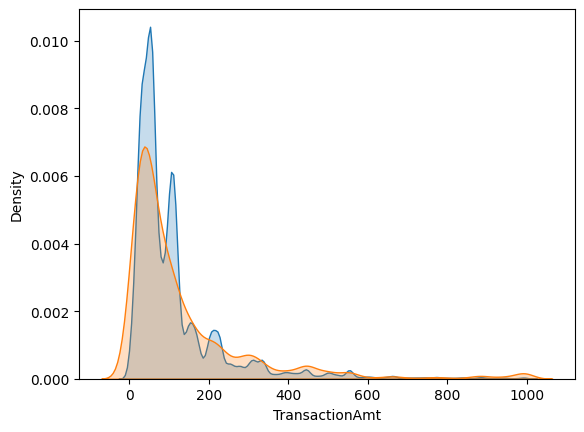

In [13]:
kdeplot_per_classes(df[df.TransactionAmt < 1000], 'TransactionAmt', 'isFraud')

<ipython-input-12-1ecaa133294e>:13: UserWarning:



`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-12-1ecaa133294e>:13: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-12-1ecaa133294e>:13: UserWarning:



`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-12-1ecaa133294e>:13: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




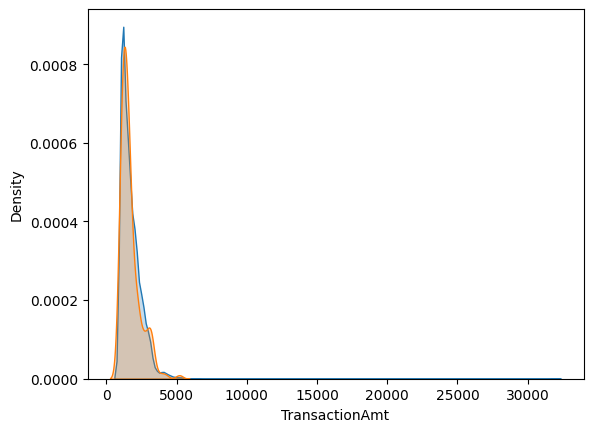

In [14]:
kdeplot_per_classes(df[df.TransactionAmt > 1000], 'TransactionAmt', 'isFraud')

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

def barplot_per_classes(df, attribute, groupby, title=None, ticks_rotation=0, topn=None, ax=None):
    """
    Draw barplot of attribute per each class.

    :param df: dataframe with data to be drawn on barplot.
    :param attribute: name of attribute to be drawn on barplot.
    :param groupby: name of attribute with predicted classes.
    :param ticks_rotation: rotation of x-ticks (labels).
    :param topn: number of top categories to be drawn.
    :param ax: matplotlib Axes object to draw the plot onto.
    """
    if ax is None:
        ax = plt.gca()  # Get current axis if none is provided

    # Filter the data to the top n values if specified
    if topn is not None:
        uniq_values = df[attribute].value_counts().head(topn).index
        df = df[df[attribute].isin(uniq_values)]

    # Calculate the percentages
    data = df.groupby([groupby, attribute]).size().reset_index(name='counts')
    total = data.groupby(groupby)['counts'].transform('sum')
    data['percentage'] = data['counts'] / total * 100

    # Create the bar plot
    sns.barplot(x=attribute, y='percentage', hue=groupby, data=data, ax=ax)

    if title:
        ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=ticks_rotation)

<ipython-input-15-f4883adcdd2b>:33: UserWarning:

FixedFormatter should only be used together with FixedLocator



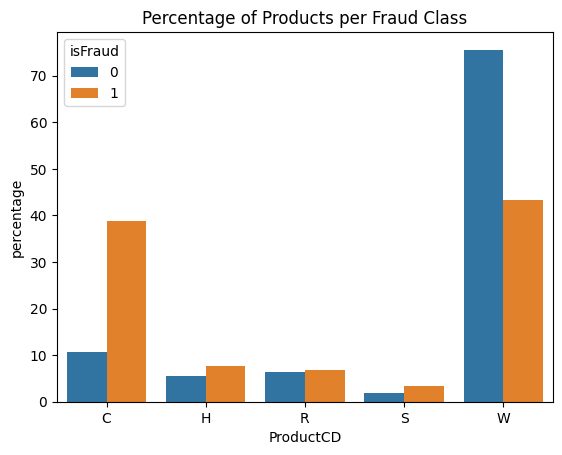

In [16]:
barplot_per_classes(df, 'ProductCD', 'isFraud', title='Percentage of Products per Fraud Class')

In [17]:
import gc
gc.collect()

3657

# Data Preprocessing


In [18]:
def drop_attributes(df, threshold):
    missing_values_ratio = df.isnull().mean()
    drop_cols = missing_values_ratio[missing_values_ratio > threshold].index
    return df.drop(columns=drop_cols)

def merge_categories(series, threshold, replacement):
    category_counts = series.value_counts(normalize=True)
    small_categories = category_counts[category_counts < threshold].index
    merge_dict = {cat: replacement for cat in small_categories}
    return series.replace(merge_dict)

def preprocess_numerical(df, threshold=0.5):
    df = drop_attributes(df, threshold)
    imputer = SimpleImputer(strategy='mean')
    numerical_cols = df.select_dtypes(include='number').columns
    df[numerical_cols] = imputer.fit_transform(df[numerical_cols])
    return df[numerical_cols]

def preprocess_categorical(df, threshold=0.5, merge_threshold=0.05, merge_replacement='Other'):
    df = drop_attributes(df, threshold)
    processed_cols = pd.DataFrame()
    for col in df.select_dtypes(include='object').columns:
        processed_col = merge_categories(df[col], merge_threshold, merge_replacement)
        processed_col.fillna(processed_col.mode()[0], inplace=True)
        processed_col = pd.get_dummies(processed_col, drop_first=True, prefix=col)
        processed_cols = pd.concat([processed_cols, processed_col], axis=1)
    return processed_cols

preprocessed_numerical_df = preprocess_numerical(df[:10000])

preprocessed_categorical_df = preprocess_categorical(df[:10000])

print("Preprocessed numerical columns:")
print(preprocessed_numerical_df)

print("\nPreprocessed categorical columns:")
print(preprocessed_categorical_df)


Preprocessed numerical columns:
      TransactionID  isFraud  TransactionDT  TransactionAmt    card1  \
0         2987000.0      0.0        86400.0           68.50  13926.0   
1         2987001.0      0.0        86401.0           29.00   2755.0   
2         2987002.0      0.0        86469.0           59.00   4663.0   
3         2987003.0      0.0        86499.0           50.00  18132.0   
4         2987004.0      0.0        86506.0           50.00   4497.0   
...             ...      ...            ...             ...      ...   
9995      2996995.0      0.0       313063.0           40.00  13052.0   
9996      2996996.0      0.0       313068.0           57.00  11137.0   
9997      2996997.0      0.0       313099.0          108.95  15627.0   
9998      2996998.0      0.0       313110.0          160.95   7207.0   
9999      2996999.0      0.0       313121.0           59.00   2803.0   

           card2  card3  card5  addr1  addr2  ...   V312        V313  \
0     349.267483  150.0  142.0 

In [19]:
preprocessed_df = pd.concat([preprocessed_numerical_df, preprocessed_categorical_df], axis=1)

print("Preprocessed DataFrame:")
preprocessed_df

Preprocessed DataFrame:


,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,card4_visa,card6_debit,P_emaildomain_anonymous.com,P_emaildomain_aol.com,P_emaildomain_gmail.com,P_emaildomain_hotmail.com,P_emaildomain_yahoo.com,M4_M1,M4_M2,M6_T
0,2987000.0,0.0,86400.0,68.50,13926.0,349.267483,150.0,142.0,315.0,87.0,...,False,False,False,False,True,False,False,False,True,True
1,2987001.0,0.0,86401.0,29.00,2755.0,404.000000,150.0,102.0,325.0,87.0,...,False,False,False,False,True,False,False,False,False,True
2,2987002.0,0.0,86469.0,59.00,4663.0,490.000000,150.0,166.0,330.0,87.0,...,True,True,False,False,False,False,False,False,False,False
3,2987003.0,0.0,86499.0,50.00,18132.0,567.000000,150.0,117.0,476.0,87.0,...,False,True,False,False,False,False,True,False,False,False
4,2987004.0,0.0,86506.0,50.00,4497.0,514.000000,150.0,102.0,420.0,87.0,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2996995.0,0.0,313063.0,40.00,13052.0,254.000000,150.0,226.0,330.0,87.0,...,True,True,False,False,True,False,False,False,False,False
9996,2996996.0,0.0,313068.0,57.00,11137.0,349.267483,150.0,226.0,387.0,87.0,...,True,True,False,False,False,False,False,False,False,False
9997,2996997.0,0.0,313099.0,108.95,15627.0,239.000000,150.0,224.0,330.0,87.0,...,False,True,False,False,True,False,False,False,False,False
9998,2996998.0,0.0,313110.0,160.95,7207.0,111.000000,150.0,226.0,204.0,87.0,...,True,True,False,False,True,False,False,False,False,False


In [20]:
preprocessed_df.to_csv('preprocessed_data.csv', index=False)

print("CSV file 'preprocessed_data.csv' has been created.")

CSV file 'preprocessed_data.csv' has been created.


In [21]:
del df

In [22]:
gc.collect()

8047

In [82]:
df_preprocessed = pd.read_csv('/content/preprocessed_data.csv')

In [83]:
df_preprocessed = df_preprocessed.sample(1000)

In [84]:
df_preprocessed

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,card4_visa,card6_debit,P_emaildomain_anonymous.com,P_emaildomain_aol.com,P_emaildomain_gmail.com,P_emaildomain_hotmail.com,P_emaildomain_yahoo.com,M4_M1,M4_M2,M6_T
4026,2991026.0,0.0,161610.0,150.000,13230.0,555.0,150.0,226.0,170.000000,87.000000,...,True,True,False,False,True,False,False,False,False,True
1122,2988122.0,0.0,121154.0,159.950,7919.0,194.0,150.0,202.0,494.000000,87.000000,...,False,True,False,False,False,False,True,False,False,True
6917,2993917.0,0.0,232429.0,97.000,7919.0,194.0,150.0,166.0,123.000000,87.000000,...,False,True,False,False,True,False,False,False,False,False
3432,2990432.0,0.0,155436.0,150.000,4219.0,321.0,150.0,226.0,472.000000,87.000000,...,True,True,False,False,True,False,False,False,False,False
1461,2988461.0,0.0,134044.0,40.000,5614.0,310.0,150.0,224.0,170.000000,87.000000,...,False,True,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,2988354.0,0.0,131858.0,200.000,18132.0,567.0,150.0,117.0,494.000000,87.000000,...,False,True,False,False,False,False,True,False,False,False
7052,2994052.0,0.0,234334.0,140.500,7919.0,194.0,150.0,166.0,325.000000,87.000000,...,False,True,False,False,True,False,False,False,False,False
2904,2989904.0,0.0,150643.0,90.268,5365.0,177.0,185.0,224.0,292.443711,87.006933,...,False,False,False,False,False,True,False,False,True,False
8518,2995518.0,0.0,254145.0,125.000,7207.0,111.0,150.0,226.0,204.000000,87.000000,...,True,True,False,False,False,False,True,False,False,False


In [85]:
X = df_preprocessed.drop('isFraud', axis=1)
y = df_preprocessed['isFraud']

# Feature selection

In [86]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
def random_undersample(x, y):
    """
    Undersample data by random choosing samples from majority class.

    :param x: train data features.
    :param y: train data labels.
    :return: x, y after undersampling.
    """
    rus = RandomUnderSampler(random_state=42)
    return rus.fit_resample(x, y)

In [88]:
%%time
x_train_undersampled, y_train_undersampled = random_undersample(x_train, y_train)
len(x_train_undersampled), len(y_train_undersampled)

CPU times: user 52 ms, sys: 967 µs, total: 52.9 ms
Wall time: 56 ms


(44, 44)

In [89]:
def custom_classification_report(clf, x_test, y_test, **kwargs):
    """
    Create custom classification report.

    :param clf: classifier model.
    :param x_test: test samples to predict labels for.
    :param y_test: true label values of test samples.
    :param confussion_matrix: wether to plut confussion matrix.
    """
    y_pred = clf.predict(x_test)
    confussion_matrix = kwargs.get('confussion_matrix', True)

    clf_report = classification_report(
        y_pred,
        y_test,
        target_names=['not fraud', 'is fraud'],
        output_dict=True
    )

    # Custom print because of incorrect formatting of original function
    for key in clf_report:
        if isinstance(clf_report[key], dict):
            print(f'\033[1m{key}\033[0m')

            for metric in clf_report[key]:
                print(f'{metric}: {clf_report[key][metric]}')
        else:
            print(f'{key}: {clf_report[key]}')

        print('\n')

    print(f'\033[1mArea Under the Receiver Operating Characteristic Curve '
          f'(ROC AUC)\033[0m')
    print(f'Score: {roc_auc_score(y_test, y_pred)}')
    print('\n')

    # if confussion_matrix:
    #     plot_confusion_matrix(clf, x_test, y_test)

In [101]:
clf = DecisionTreeClassifier(random_state=42, class_weight='balanced')
# clf = RandomForestClassifier(n_estimators=200, random_state=0)
clf = clf.fit(x_train, y_train)

In [102]:
custom_classification_report(clf, x_test, y_test)

not fraud
precision: 0.9746192893401016
recall: 0.9846153846153847
f1-score: 0.979591836734694
support: 195


is fraud
precision: 0.0
recall: 0.0
f1-score: 0.0
support: 5


accuracy: 0.96


macro avg
precision: 0.4873096446700508
recall: 0.49230769230769234
f1-score: 0.489795918367347
support: 200


weighted avg
precision: 0.950253807106599
recall: 0.96
f1-score: 0.9551020408163267
support: 200


Area Under the Receiver Operating Characteristic Curve (ROC AUC)
Score: 0.4873096446700508




In [103]:
%%time
clf = DecisionTreeClassifier(random_state=42)
clf = clf.fit(x_train_undersampled, y_train_undersampled)

CPU times: user 30.9 ms, sys: 963 µs, total: 31.9 ms
Wall time: 119 ms


In [104]:
%%time
custom_classification_report(clf, x_test, y_test)

not fraud
precision: 0.5786802030456852
recall: 0.991304347826087
f1-score: 0.7307692307692308
support: 115


is fraud
precision: 0.6666666666666666
recall: 0.023529411764705882
f1-score: 0.045454545454545456
support: 85


accuracy: 0.58


macro avg
precision: 0.622673434856176
recall: 0.5074168797953964
f1-score: 0.3881118881118881
support: 200


weighted avg
precision: 0.6160744500846023
recall: 0.58
f1-score: 0.43951048951048954
support: 200


Area Under the Receiver Operating Characteristic Curve (ROC AUC)
Score: 0.6226734348561759


CPU times: user 32.8 ms, sys: 0 ns, total: 32.8 ms
Wall time: 38.4 ms


Optimal number of features: 42


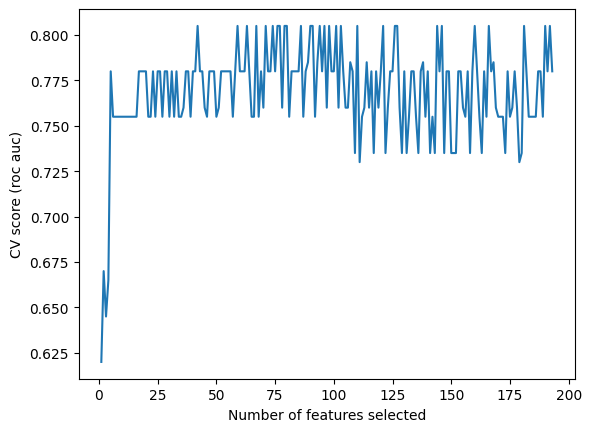

CPU times: user 594 ms, sys: 321 ms, total: 915 ms
Wall time: 5.06 s


In [105]:
%%time
rfecv = RFECV(estimator=clf, scoring='roc_auc', n_jobs=-1)
rfecv.fit(x_train_undersampled, y_train_undersampled)

selected_columns = [col for col, selected in zip(x_train.columns, rfecv.support_) if selected]

print(f'Optimal number of features: {rfecv.n_features_}')

plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('CV score (roc auc)')
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score'] ) + 1), rfecv.cv_results_['mean_test_score'] )
plt.show()

In [106]:
%%time
custom_classification_report(rfecv.estimator_, x_test[selected_columns], y_test)

not fraud
precision: 0.5786802030456852
recall: 0.991304347826087
f1-score: 0.7307692307692308
support: 115


is fraud
precision: 0.6666666666666666
recall: 0.023529411764705882
f1-score: 0.045454545454545456
support: 85


accuracy: 0.58


macro avg
precision: 0.622673434856176
recall: 0.5074168797953964
f1-score: 0.3881118881118881
support: 200


weighted avg
precision: 0.6160744500846023
recall: 0.58
f1-score: 0.43951048951048954
support: 200


Area Under the Receiver Operating Characteristic Curve (ROC AUC)
Score: 0.6226734348561759


CPU times: user 27.1 ms, sys: 2.76 ms, total: 29.9 ms
Wall time: 30 ms


In [125]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def split(df,label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te



classifiers = ['LinearSVM', 'RadialSVM',
               'Logistic',  'RandomForest',
               'AdaBoost',  'DecisionTree',
               'KNeighbors','GradientBoosting']

models = [svm.SVC(kernel='linear'),
          svm.SVC(kernel='rbf'),
          LogisticRegression(max_iter = 1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          AdaBoostClassifier(random_state = 0),
          DecisionTreeClassifier(random_state=0),
          KNeighborsClassifier(),
          GradientBoostingClassifier(random_state=0)]


def acc_score(df,label):
    Score = pd.DataFrame({"Classifier":classifiers})
    j = 0
    acc = []
    X_train,X_test,Y_train,Y_test = split(df,label)
    for i in models:
        model = i
        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test,predictions))
        j = j+1
    Score["Accuracy"] = acc
    Score.sort_values(by="Accuracy", ascending=False,inplace = True)
    Score.reset_index(drop=True, inplace=True)
    return Score

def plot(score,x,y,c = "b", size = 10):
    gen = [i for i in range(size)]
    plt.figure(figsize=(6,4))
    ax = sns.pointplot(x=gen, y=score,color = c )
    ax.set(xlabel="Generation", ylabel="Accuracy")
    ax.set(ylim=(x,y))

In [126]:
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=bool)
        chromosome[:int(0.3*n_feat)]=False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population


def fitness_score(population,X_train, X_test, Y_train, Y_test):
    scores = []
    for chromosome in population:
        logmodel.fit(X_train.iloc[:,chromosome],Y_train)
        predictions = logmodel.predict(X_test.iloc[:,chromosome])
        scores.append(accuracy_score(Y_test,predictions))
    scores, population = np.array(scores), np.array(population)
    inds = np.argsort(scores)
    return list(scores[inds][::-1]), list(population[inds,:][::-1])


def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen


def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]
        new_par = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen


def mutation(pop_after_cross,mutation_rate,n_feat):
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = []
        for i in range(0,mutation_range):
            pos = randint(0,n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]
        pop_next_gen.append(chromo)
    return pop_next_gen

def generations(size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                   X_test, Y_train, Y_test):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen,X_train,
                                   X_test, Y_train, Y_test)
        print('Best score in generation',i+1,':',scores[:1])  #2
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score

In [127]:
score3 = acc_score(x_train,y_train)
score3

,Classifier,Accuracy
0,RadialSVM,0.985
1,RandomForest,0.985
2,AdaBoost,0.985
3,KNeighbors,0.985
4,Logistic,0.980
5,GradientBoosting,0.980
6,LinearSVM,0.975
7,DecisionTree,0.950


In [124]:
logmodel = DecisionTreeClassifier(random_state=0)
chromo_df_pd,score_pd=generations(size=10,n_feat=x_train.shape[1],n_parents=5,mutation_rate=0.20,n_gen=10,
                         X_train = x_train,X_test = x_test,Y_train = y_train,Y_test = y_test)

Best score in generation 1 : [0.975]
Best score in generation 2 : [0.975]
Best score in generation 3 : [0.98]
Best score in generation 4 : [0.975]
Best score in generation 5 : [0.975]
Best score in generation 6 : [0.98]
Best score in generation 7 : [0.98]
Best score in generation 8 : [0.975]
Best score in generation 9 : [0.98]
Best score in generation 10 : [0.985]


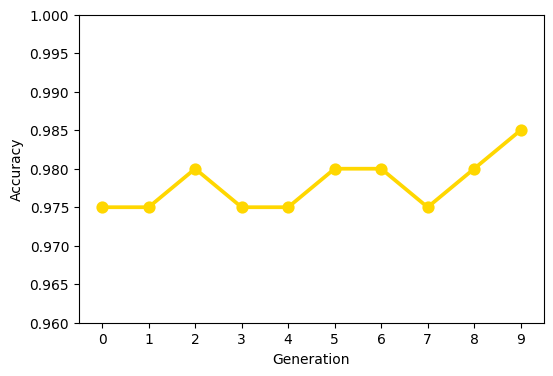

In [128]:
plot(score_pd,0.96,1.0,c = "gold")

In [129]:
!pip install pyswarms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.2 MB/s eta 0:00:00


In [130]:
import numpy as np
import pyswarms as ps



X = df_preprocessed.drop('isFraud', axis=1).values  # Feature matrix
y = df_preprocessed['isFraud'].values  # Target variable

# Define binary PSO
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Define bounds
max_bound = 1.0 * np.ones(X.shape[1])
min_bound = 0.0 * np.ones(X.shape[1])
bounds = (min_bound, max_bound)

# Objective function
def f_per_particle(m, alpha):
    """Computes for the objective function per particle

    Inputs
    ------
    m : numpy.ndarray
        Binary mask that can be obtained from BinaryPSO, will
        be used to mask features.
    alpha: float
        Penalty factor to control the number of features selected.

    Returns
    -------
    numpy.ndarray
    """
    total_features = X.shape[1]
    # Apply mask to features
    X_subset = X[:,m>0.5]
    if X_subset.shape[1] == 0:
        return float('inf')
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.3, random_state=42)
    # Fit the model
    clf = RandomForestClassifier(n_estimators=50, random_state=42)
    clf.fit(X_train, y_train)
    # Predict and calculate accuracy
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    # Calculate objective
    j = (alpha * (1.0 - accuracy) + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))
    return j

# Define objective function
def f(x, alpha=0.5):
    """Higher-level method to do classification in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

# Initialize swarm
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=X.shape[1], options=options, bounds=bounds)

# Perform optimization
cost, pos = optimizer.optimize(f, iters=100)

2024-04-29 20:38:34,936 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.166
2024-04-29 20:44:26,888 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.16618307426597578, best pos: [0.54646483 0.45156812 0.22076204 0.67837355 0.78685017 0.8204559
 0.42595275 0.37097298 0.21112956 0.57606354 0.70523409 0.68456037
 0.04804275 0.6213544  0.53212538 0.41189087 0.62438928 0.10478188
 0.7153446  0.01590484 0.55635599 0.6044622  0.12254331 0.53737145
 0.76265527 0.55340321 0.97627435 0.25679344 0.93607596 0.53071599
 0.84662094 0.90416793 0.81703428 0.73346926 0.89779828 0.46221784
 0.29768965 0.9697928  0.78510969 0.82690566 0.61920277 0.8003474
 0.74176516 0.76029513 0.85996463 0.05043344 0.98998149 0.42081967
 0.5326126  0.98016403 0.70168374 0.97949162 0.39159872 0.90040254
 0.32213303 0.90667354 0.84554767 0.79185443 0.12422631 0.86513639
 0.881545

In [131]:
#'pos' is the variable containing the best position returned by optimizer.optimize()
best_pos = np.array(pos)

print("Position as NumPy Array:", best_pos)

Position as NumPy Array: [0.54646483 0.45156812 0.22076204 0.67837355 0.78685017 0.8204559
 0.42595275 0.37097298 0.21112956 0.57606354 0.70523409 0.68456037
 0.04804275 0.6213544  0.53212538 0.41189087 0.62438928 0.10478188
 0.7153446  0.01590484 0.55635599 0.6044622  0.12254331 0.53737145
 0.76265527 0.55340321 0.97627435 0.25679344 0.93607596 0.53071599
 0.84662094 0.90416793 0.81703428 0.73346926 0.89779828 0.46221784
 0.29768965 0.9697928  0.78510969 0.82690566 0.61920277 0.8003474
 0.74176516 0.76029513 0.85996463 0.05043344 0.98998149 0.42081967
 0.5326126  0.98016403 0.70168374 0.97949162 0.39159872 0.90040254
 0.32213303 0.90667354 0.84554767 0.79185443 0.12422631 0.86513639
 0.88154598 0.81705042 0.89958004 0.89004319 0.50474339 0.45967056
 0.60196873 0.61226488 0.00403904 0.05257325 0.59099339 0.74914596
 0.82945285 0.86713564 0.45262685 0.71384224 0.6827     0.23353532
 0.52781904 0.9798796  0.76034966 0.88479676 0.08613415 0.24701229
 0.48046472 0.7556608  0.98109927 0.066

In [137]:
# Define a threshold to determine whether a feature is selected
threshold = 0.6

# Create a boolean mask from 'best_pos' based on the threshold
selected_features_mask = best_pos > threshold

# df_cleaned.columns[:-1] gives you all feature names excluding the target variable
feature_names = df_preprocessed.columns[:-1]  # Modify this as necessary

# Use the mask to select the names of the features
selected_features = feature_names[selected_features_mask]
print(len(feature_names))
print(len(selected_features))
print("Selected Features:", selected_features)

193
102
Selected Features: Index(['TransactionAmt', 'card1', 'card2', 'C1', 'C2', 'C4', 'C7', 'C9', 'C12',
       'D1',
       ...
       'V314', 'V315', 'V317', 'V318', 'V321', 'ProductCD_H',
       'ProductCD_Other', 'ProductCD_W', 'P_emaildomain_aol.com',
       'P_emaildomain_gmail.com'],
      dtype='object', length=102)


In [141]:
list_features = list(selected_features)
# list_features.remove('isFraud')
list_features = list_features[:15]

In [142]:
score3 = acc_score(x_train[list_features],y_train)
score3

,Classifier,Accuracy
0,LinearSVM,0.985
1,RadialSVM,0.985
2,Logistic,0.985
3,RandomForest,0.985
4,KNeighbors,0.985
5,GradientBoosting,0.985
6,AdaBoost,0.980
7,DecisionTree,0.950
